In [1]:
#Importing packages and libraries
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading csv into env for analysis
tc = pd.read_csv('teleco_time_series .csv')
pd.set_option('display.max_columns', None)
tc.head()

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554


In [3]:
#exploring data set
tc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.5 KB


In [4]:
#check for duplicates
tc.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
726    False
727    False
728    False
729    False
730    False
Length: 731, dtype: bool

In [5]:
tc.drop_duplicates(keep='last')

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554
...,...,...
726,727,16.931559
727,728,17.490666
728,729,16.803638
729,730,16.194813


In [6]:
#checking for null values
tc.isnull().sum()

Day        0
Revenue    0
dtype: int64

In [7]:
#viewing overall shape
tc.shape

(731, 2)

In [8]:
# formating a start date, in datetime object format 
start_date = pd.to_datetime('2020-01-01')
# Converted day column
tc['Day'] = pd.to_timedelta(tc['Day']-1, unit='D') + start_date

In [9]:
#renaming day to date to make it more ideal, set index
tc = tc.rename(columns = {"Day": "Date"})
tc.set_index('Date', inplace=True)
tc

,Revenue
Date,
2020-01-01,0.000000
2020-01-02,0.000793
2020-01-03,0.825542
2020-01-04,0.320332
2020-01-05,1.082554
...,...
2021-12-27,16.931559
2021-12-28,17.490666
2021-12-29,16.803638


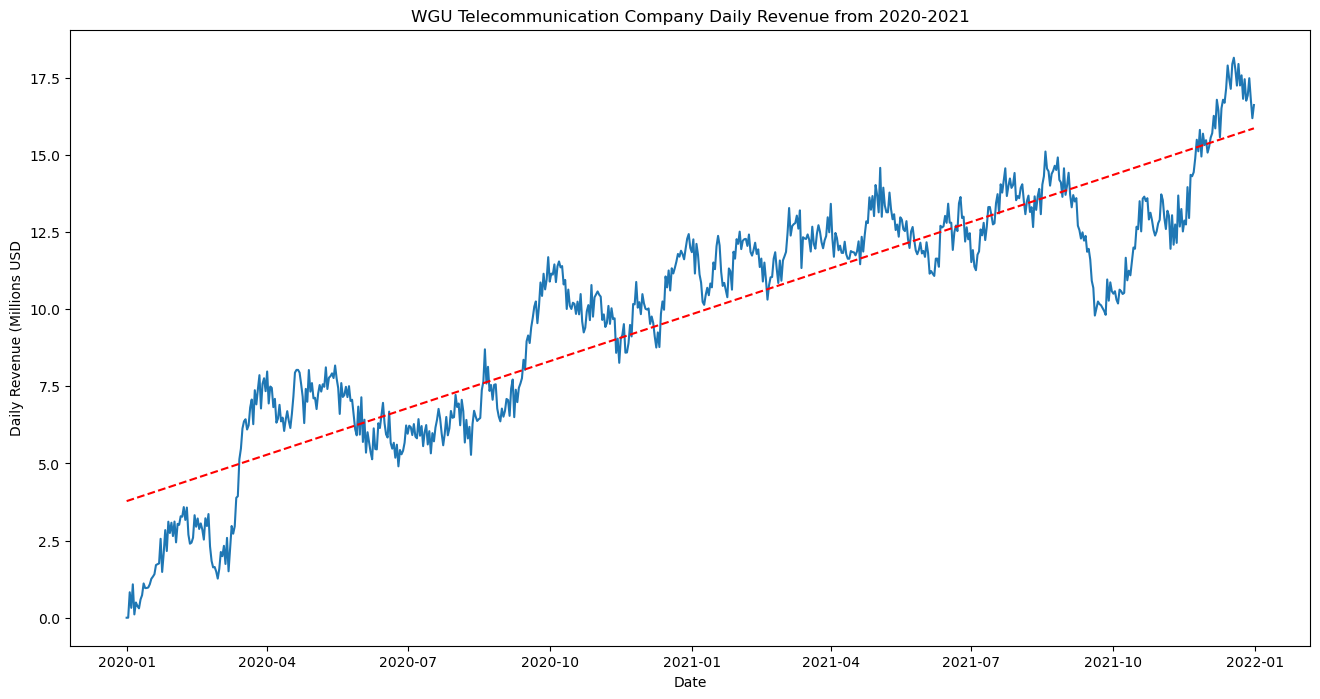

In [10]:
# plotting time series of original data
plt.figure(figsize = [16,8])
plt.title("WGU Telecommunication Company Daily Revenue from 2020-2021")
plt.xlabel("Date")
plt.ylabel("Daily Revenue (Millions USD")
plt.plot(tc)
x = mdates.date2num(tc.index)
y = tc.Revenue
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# Plot trendline
plt.plot(x, p(x), "r--")
plt.show()

In [11]:
#difference dataset, make stationary
tc_clean = tc.diff().dropna()

In [12]:
# Save cleaned tc to csv
tc_clean.to_csv('AFD213Tk1_clean.csv')

In [13]:
#computing Augmented Dickey-Fuller test on original data
fuller_original = adfuller(tc.Revenue)
#test statistic, p-value, crit. values of original data
print(f"Test statistic: {round(fuller_original[0], 4)}")
print(f"P-value: {round(fuller_original[1], 4)}")
print(f"Critical Values:{fuller_original[4]}")

Test statistic: -1.9246
P-value: 0.3206
Critical Values:{'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [14]:
#H0: Time Series is not stationary, Ha Time Series is stationary
#Print results of hypothesis testing to confirm stationarity of original data
if fuller_original[1]<= 0.05:
    print(f"Reject Null'H0' Hypothesis, time series is stationary")
else:
    print(f"Fail to reject Null'H0' Hypothesis, time series is not stationary")

Fail to reject Null'H0' Hypothesis, time series is not stationary


In [15]:
#computing Augmented Dickey-Fuller test on clean data
fuller_results = adfuller(tc_clean.Revenue)
#test statistic, p-value, crit. values of clean data
print(f"Test statistic: {round(fuller_results[0], 4)}")
print(f"P-value: {round(fuller_results[1], 4)}")
print(f"Critical Values:{fuller_results[4]}")

Test statistic: -44.8745
P-value: 0.0
Critical Values:{'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [16]:
#H0: Time Series is not stationary, Ha Time Series is stationary
#Print results of hypothesis testing to confirm stationarity of clean data
if fuller_results[1]<= 0.05:
    print(f"Reject Null'H0' Hypothesis, time series is stationary")
else:
    print(f"Fail to reject Null'H0' Hypothesis, time series is not stationary")

Reject Null'H0' Hypothesis, time series is stationary


<AxesSubplot: xlabel='Date'>

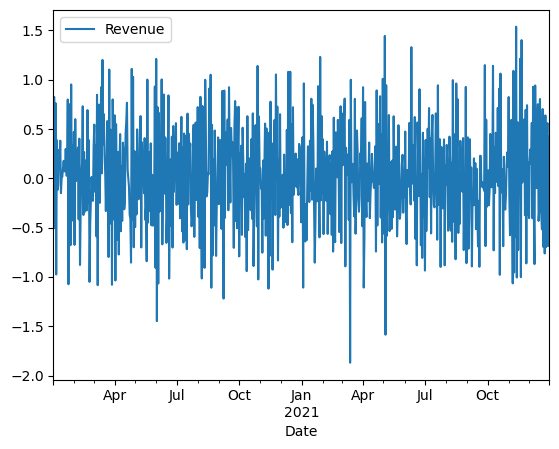

In [17]:
# Plot to verify stationarity
tc_clean.plot()

In [18]:
# Split time series into a training set and a testing set
train_tc, test_tc = train_test_split(tc_clean, test_size=0.2,
                                     shuffle=False, random_state=397)

#viewing training data set
train_tc

,Revenue
Date,
2020-01-02,0.000793
2020-01-03,0.824749
2020-01-04,-0.505210
2020-01-05,0.762222
2020-01-06,-0.974900
...,...
2021-08-03,0.113264
2021-08-04,-0.531705
2021-08-05,-0.437835


In [19]:
#viewing test data set
test_tc

,Revenue
Date,
2021-08-08,-0.531923
2021-08-09,0.157387
2021-08-10,-0.644689
2021-08-11,0.995057
2021-08-12,-0.438775
...,...
2021-12-27,0.170280
2021-12-28,0.559108
2021-12-29,-0.687028


In [20]:
# Save train tc to csv
train_tc.to_csv('AFD213Tk1_train_clean.csv')
# Save test tc to csv
test_tc.to_csv('AFD213Tk1_test_clean.csv')

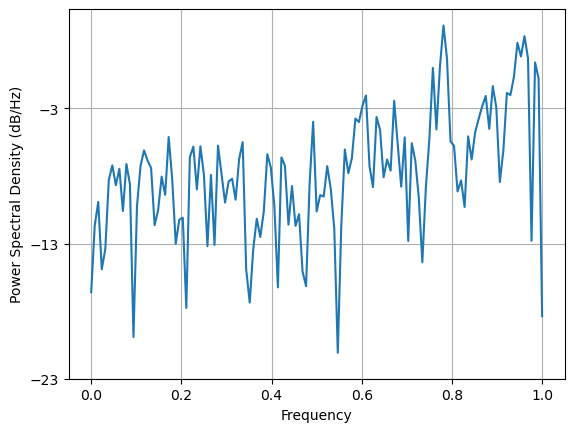

In [21]:
##spectral density
plt.psd(x=tc_clean.Revenue);

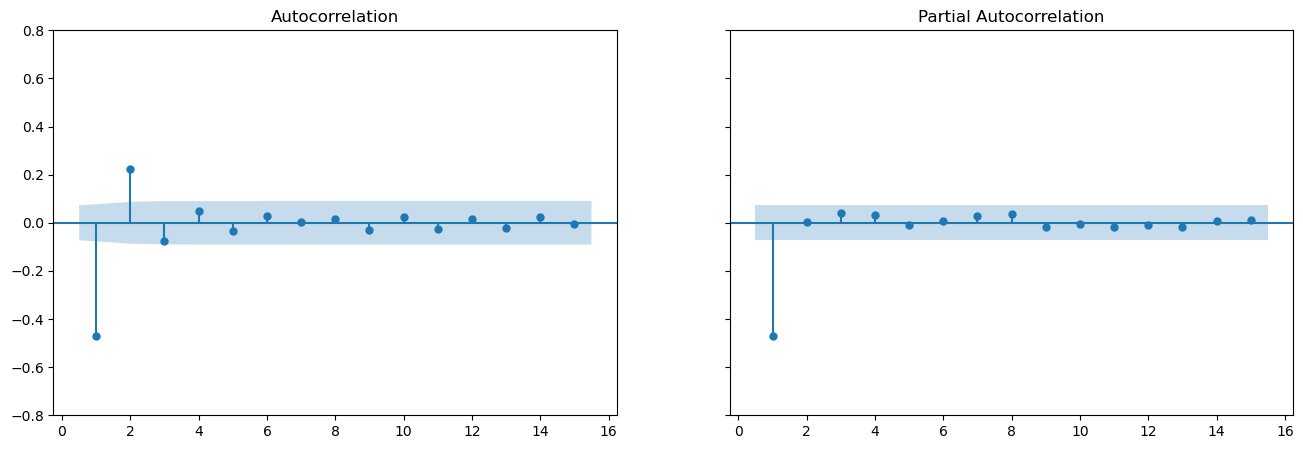

In [22]:
# Plot ACF and PACF on difference data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,5], sharey=True)
# Plot ACF  ignore zero
plot_acf(tc_clean, lags=15, zero=False, ax=ax1)
# Plot PACF ignore zero 
plot_pacf(tc_clean, lags=15, zero=False,ax=ax2)
plt.ylim(-0.8, 0.8);

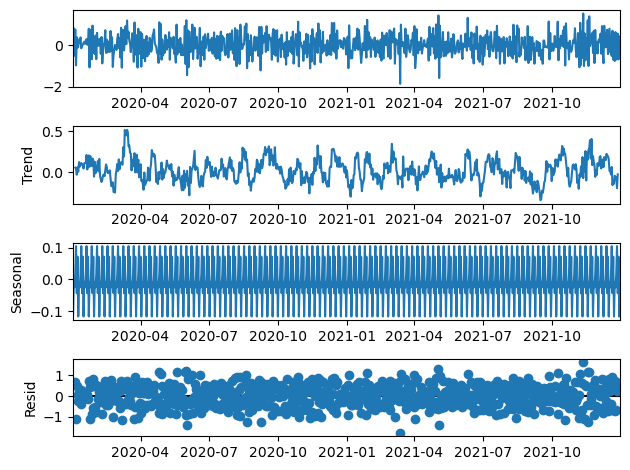

In [23]:
# Decompose the clean data set, plot time series
decomp_tc = seasonal_decompose(tc_clean)
decomp_tc.plot()
plt.show();

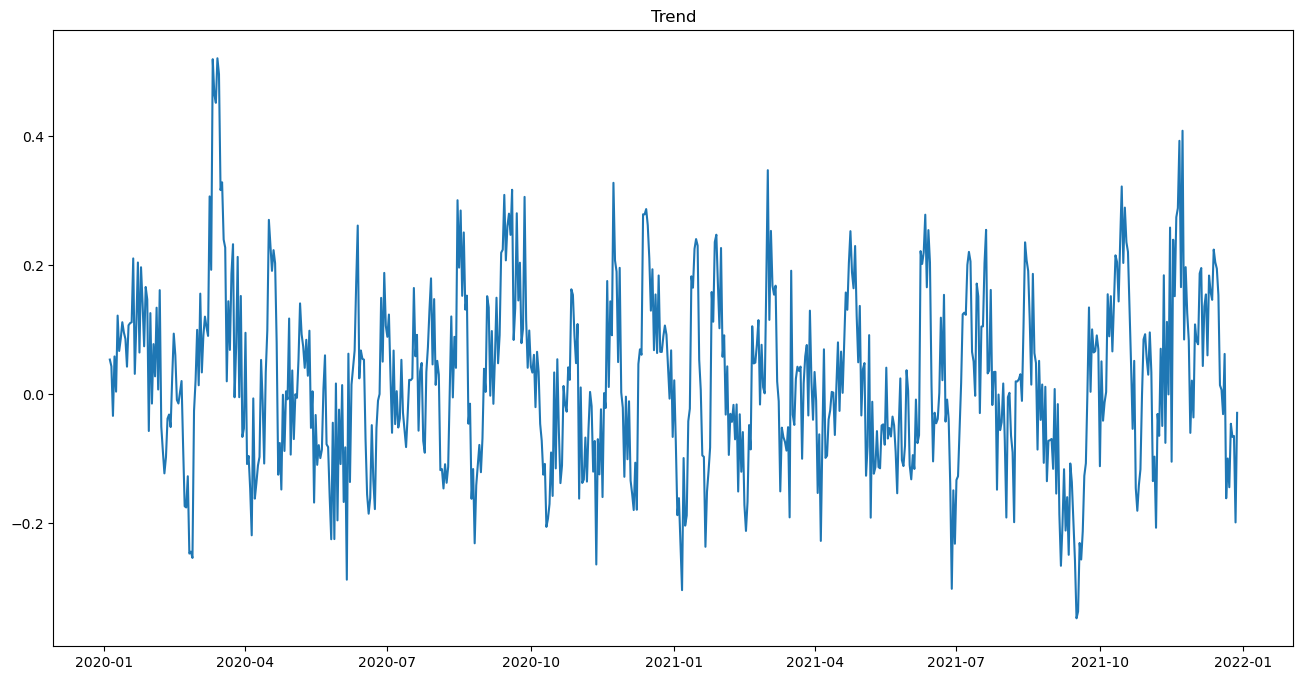

In [24]:
# viewing plot of trend.
plt.figure(figsize = [16,8])
plt.title('Trend')
plt.plot(decomp_tc.trend);

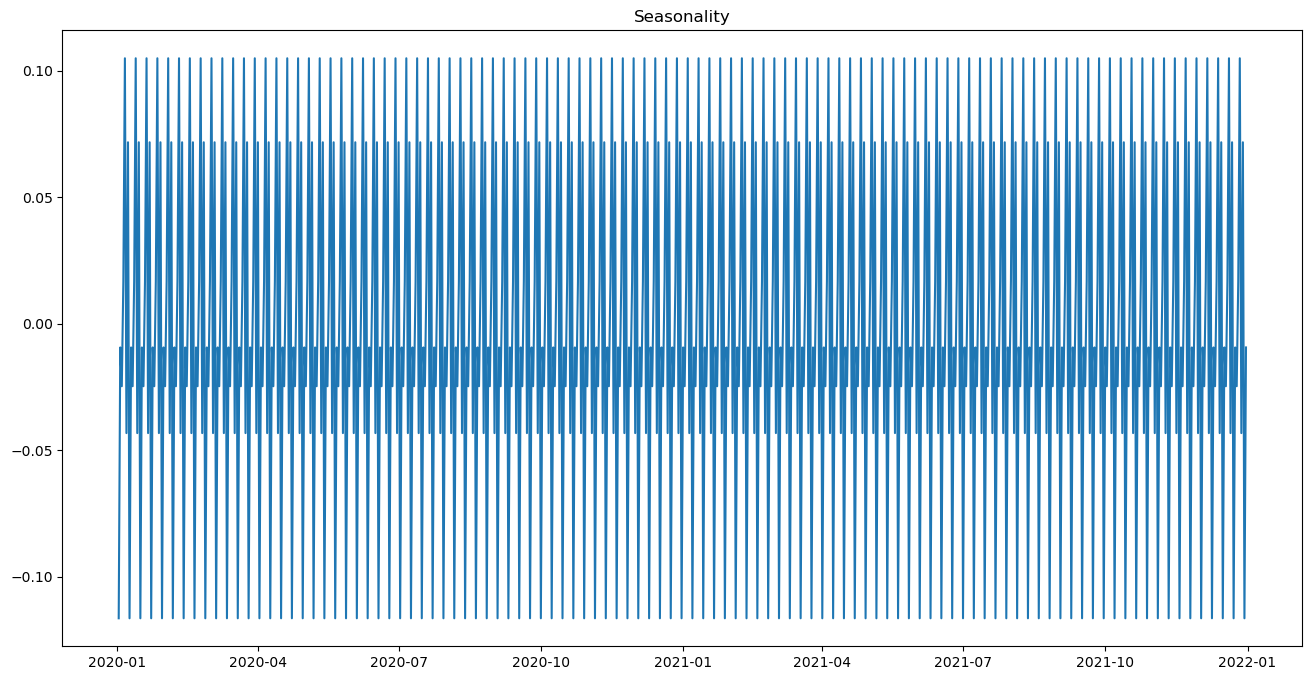

In [25]:
#viewing plot of seasonality
plt.figure(figsize = [16,8])
plt.title('Seasonality')
plt.plot(decomp_tc.seasonal);

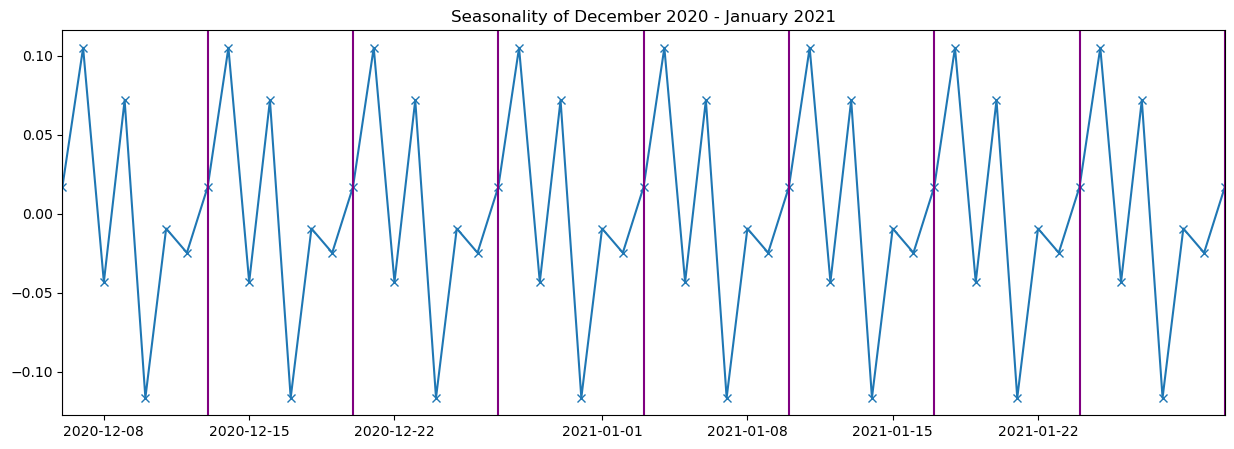

In [26]:
#seasonality on weekly level viewed December-January, purple line: Sundays (Unknown,n.d.).
plt.figure(figsize = [15,5])
plt.plot(decomp_tc.seasonal, marker='x')
plt.xlim(pd.to_datetime('2020-12-06'), pd.to_datetime('2021-01-31'))
plt.title('Seasonality of December 2020 - January 2021')
plt.axvline(x=pd.to_datetime('2020-12-06'), color='purple')
plt.axvline(x=pd.to_datetime('2020-12-13'), color='purple')
plt.axvline(x=pd.to_datetime('2020-12-20'), color='purple')
plt.axvline(x=pd.to_datetime('2020-12-27'), color='purple')
plt.axvline(x=pd.to_datetime('2021-01-03'), color='purple')
plt.axvline(x=pd.to_datetime('2021-01-10'), color='purple')
plt.axvline(x=pd.to_datetime('2021-01-17'), color='purple')
plt.axvline(x=pd.to_datetime('2021-01-24'), color='purple')
plt.axvline(x=pd.to_datetime('2021-01-31'), color='purple');

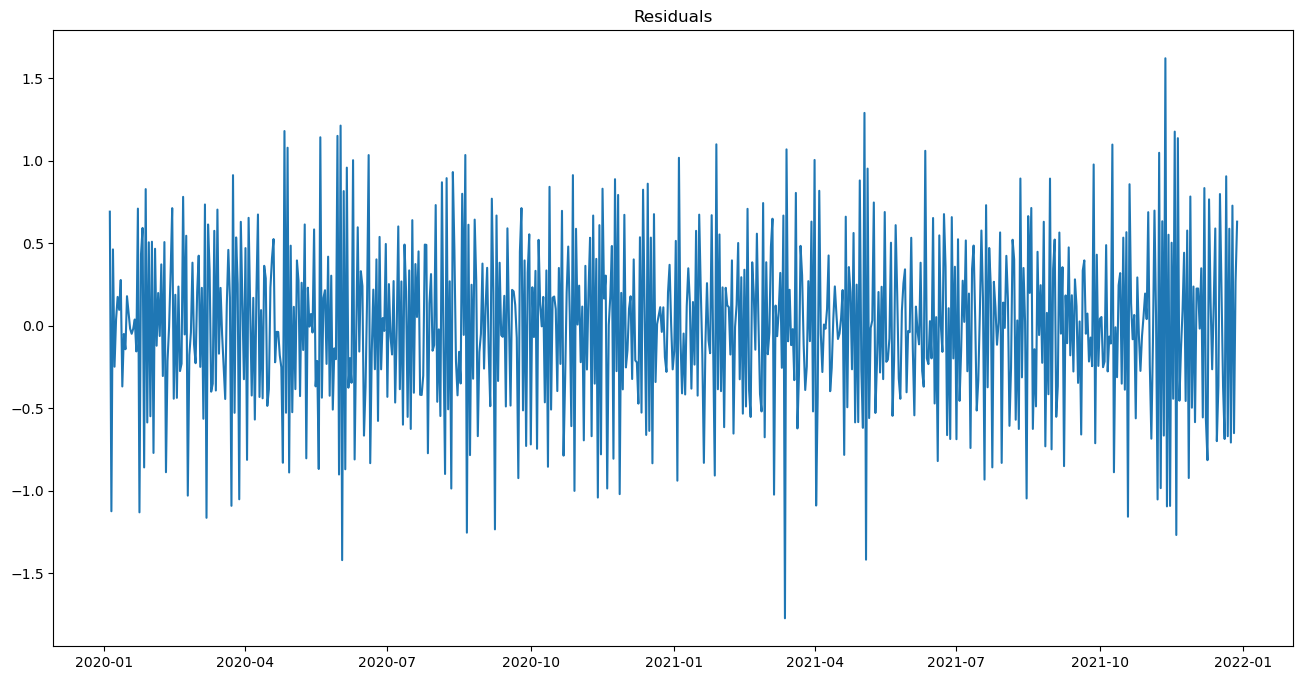

In [27]:
# residual components plot
plt.figure(figsize = [16,8])
plt.title('Residuals')
plt.plot(decomp_tc.resid);

In [28]:
#auto_arima to get best parameters(Pulagam,2020).
auto_arima(
    train_tc["Revenue"], 
    start_p = 1, max_p = 6, 
    start_q = 1, max_q = 6, 
    seasonal = False, trace = True).summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=776.989, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=909.948, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=774.990, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=801.099, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=776.989, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=778.497, Time=0.41 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=773.893, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=910.790, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=775.886, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=775.888, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=799.464, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=777.694, Time=0.94 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 2.987 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  584
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -383.946
Date:                Mon, 07 Aug 2023   AIC                            773.893
Time:                        22:26:18   BIC                            787.002
Sample:                    01-02-2020   HQIC                           779.002
                         - 08-07-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0341      0.019      1.751      0.080      -0.004       0.072
ar.L1         -0.4597      0.036    -12.654      0.000      -0.531      -0.388
sigma2         0.2180      0.014     16.034      0.000       0.191       0.245
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.84
Prob(Q):                              0.96   Prob(JB):                         0.40
Heteroskedasticity (H):               0.97   Skew:                            -0.08
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
#ARIMA model of time series using best parameters from auto arima(Elleh, n.d.).
arima_model = ARIMA(train_tc, order=(1, 0, 0), freq='D')
results = arima_model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -383.946
Date:                Mon, 07 Aug 2023   AIC                            773.893
Time:                        22:26:18   BIC                            787.002
Sample:                    01-02-2020   HQIC                           779.002
                         - 08-07-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0234      0.013      1.758      0.079      -0.003       0.049
ar.L1         -0.4597      0.036    -12.654      0.000      -0.531      -0.388
sigma2         0.2180      0.014     16.034      0.0

In [30]:
#AIC
results.aic

773.8925878321593

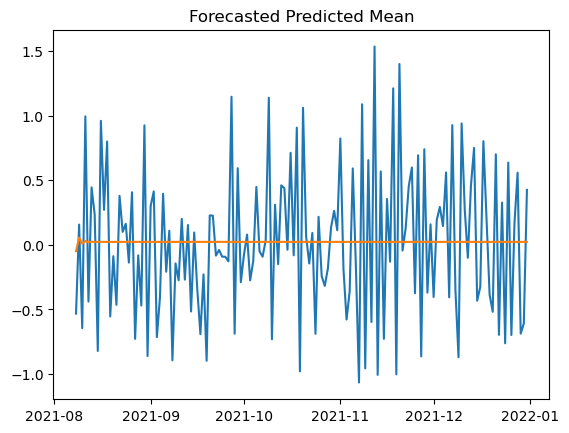

In [31]:
#forecasted mean(Pathak, 2020).
forecasted = results.get_prediction(start = 584, end = 729, dynamic = True)
plt.plot(test_tc)
plt.title('Forecasted Predicted Mean')
plt.plot(forecasted.predicted_mean);

In [32]:
print(forecasted.predicted_mean)

2021-08-08   -0.048621
2021-08-09    0.056441
2021-08-10    0.008147
2021-08-11    0.030347
2021-08-12    0.020142
                ...   
2021-12-27    0.023356
2021-12-28    0.023356
2021-12-29    0.023356
2021-12-30    0.023356
2021-12-31    0.023356
Freq: D, Name: predicted_mean, Length: 146, dtype: float64


In [33]:
# forecasted differences into a temp dataframe(Pathak, 2020).
fore_temp = pd.DataFrame(forecasted.predicted_mean)
fore_temp.rename(columns={'predicted_mean' : 'Revenue'}, inplace=True)

# Concat copy of train data & forecasted values
tc_forecast = pd.concat([train_tc.copy(), fore_temp.copy()])
tc_forecast = tc_forecast.cumsum()
tc_forecast

,Revenue
2020-01-02,0.000793
2020-01-03,0.825542
2020-01-04,0.320332
2020-01-05,1.082554
2020-01-06,0.107654
...,...
2021-12-27,16.952019
2021-12-28,16.975375
2021-12-29,16.998730
2021-12-30,17.022086


In [34]:
# confidence intervals from forecasted
confid_intv = forecasted.conf_int()
confid_intv

,lower Revenue,upper Revenue
2021-08-08,-0.963665,0.866422
2021-08-09,-0.950645,1.063528
2021-08-10,-1.017331,1.033625
2021-08-11,-0.998976,1.059669
2021-08-12,-1.009990,1.050275
...,...,...
2021-12-27,-1.006994,1.053705
2021-12-28,-1.006994,1.053705
2021-12-29,-1.006994,1.053705
2021-12-30,-1.006994,1.053705


In [35]:
# df to match confidence intervals from orginal data pt 2021-08-07(Pathak, 2020).
pr = pd.DataFrame({'lower Revenue': [13.684826], 
                             'upper Revenue' : [13.684826], 'Date' : ['2021-08-07']})
# Convert given date string to datetime and then set as index
pr['Date'] = pd.to_datetime(pr['Date'])
pr.set_index('Date', inplace=True)
pr

,lower Revenue,upper Revenue
Date,,
2021-08-07,13.684826,13.684826


In [36]:
# Concat the previous row & confidence intervals
confid_intv = pd.concat([pr, confid_intv])

# Untransform the confidence intervals using cumsum()
confid_intv = confid_intv.cumsum()

# Setting range of data
confid_intv = confid_intv.loc['2021-08-08' : '2021-12-31']
confid_intv

,lower Revenue,upper Revenue
2021-08-08,12.721161,14.551248
2021-08-09,11.770516,15.614775
2021-08-10,10.753185,16.648401
2021-08-11,9.754210,17.708069
2021-08-12,8.744219,18.758344
...,...,...
2021-12-27,-129.212872,163.116910
2021-12-28,-130.219866,164.170616
2021-12-29,-131.226860,165.224321
2021-12-30,-132.233854,166.278026


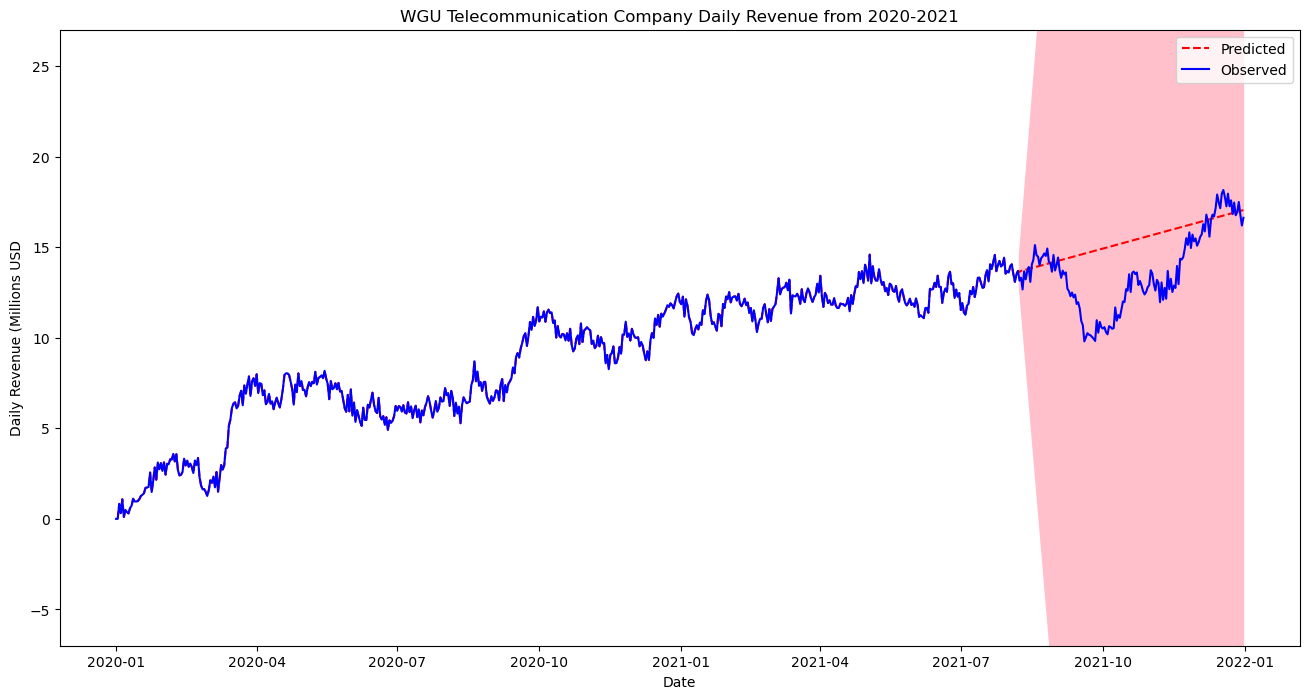

In [37]:
#forecasted(Elleh, n.d.). 
plt.figure(figsize = [16,8])
plt.title("WGU Telecommunication Company Daily Revenue from 2020-2021")
plt.xlabel("Date")
plt.ylabel("Daily Revenue (Millions USD")

# forecasted data
plt.plot(tc_forecast, color = 'red', linestyle = 'dashed')
# Plot using original dataset
plt.plot(tc, color = 'blue')
# confidence intervals
plt.fill_between(confid_intv.index, confid_intv['lower Revenue'], 
                 confid_intv['upper Revenue'], color = 'pink')
plt.ylim(-7, 27)
plt.legend(['Predicted', 'Observed'])
plt.show();

In [38]:
# Calculate root mean squared error of forecasted data vs the observed data
rmse = mean_squared_error(tc.loc['2021-08-08' : '2021-12-31'], 
                          tc_forecast.Revenue.loc['2021-08-08' : '2021-12-31'],
                          squared=False)
print(f"RMSE: {round(rmse, 5)}")

RMSE: 2.47394
